In [1]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import matplotlib.pyplot as plt

import catboost

# Загружаем данные

In [2]:
train_data_path = 'contest_train.csv'
test_data_path = 'contest_test.csv'

In [3]:
df_train = pd.read_csv(train_data_path, sep=',', header=0)
df_test = pd.read_csv(test_data_path, sep=',', header=0)

# Tiny EDA
Посмотрим, есть ли дизбаланс

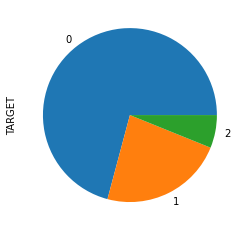

In [4]:
df_train['TARGET'].value_counts().plot(kind='pie')

Теперь посмотрим на тип данных в фичах

In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24521 entries, 0 to 24520
Columns: 262 entries, ID to FEATURE_259
dtypes: float64(260), int64(2)
memory usage: 49.0 MB


Посмотрим, есть ли нулевые значения в фичах в трейне, и если они есть, какой их процент

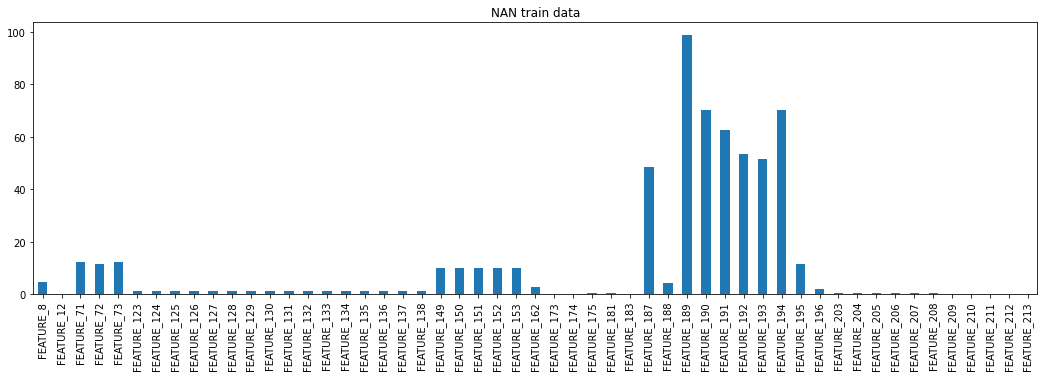

In [6]:
null_df_train = (df_train.isna().sum() / len(df_train) * 100)
null_df_train = null_df_train[null_df_train != 0]
null_df_train.plot(kind='bar', figsize=(18,5), title='NAN train data')

Посмотрим, есть ли нулевые значения в фичах в тесте, и если они есть, какой их процент

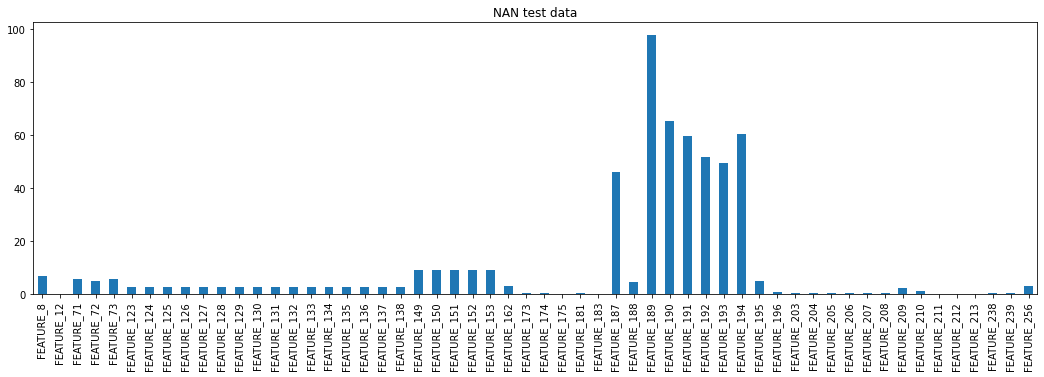

In [7]:
null_df_test = (df_test.isna().sum() / len(df_test) * 100)
null_df_test = null_df_test[null_df_test != 0]
null_df_test.plot(kind='bar', figsize=(18,5), title='NAN test data')

Судя по графикам, фичи с NAN в тесте и трейне не совпадают. Проверим, какое множество фич имеет больше NAN-значений

In [8]:
set(null_df_train.keys()).difference(set(null_df_test.keys()))

set()

In [9]:
set(null_df_test.keys()).difference(set(null_df_train.keys()))

{'FEATURE_238', 'FEATURE_239', 'FEATURE_256'}

Судя по результатам выше, фичи ('FEATURE_238', 'FEATURE_239', 'FEATURE_256') с NAN-значениями есть только в тесте. Если посмотреть на график, там не так много NAN-значений. Посмотрим, какие там вообще значения

In [10]:
df_test['FEATURE_238'].describe()

count    9448.000000
mean      107.702794
std       159.322007
min         0.000000
25%        14.000000
50%        53.000000
75%       137.000000
max      3218.000000
Name: FEATURE_238, dtype: float64

In [11]:
df_test['FEATURE_239'].describe()

count    9448.000000
mean      108.733171
std       131.547537
min         0.000000
25%        25.000000
50%        66.000000
75%       144.000000
max      1755.000000
Name: FEATURE_239, dtype: float64

In [12]:
df_test['FEATURE_256'].describe()

count    9211.000000
mean        0.213549
std         0.409834
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: FEATURE_256, dtype: float64

Фича FEATURE_256 бинарная, значений 0 больше, чем 1. Заполним NAN-значения этой фичи в тесте нулями

In [13]:
df_test['FEATURE_256'].fillna((0.0), inplace=True)

Фичи FEATURE_238 и FEATURE_239 непрерывные. Заполним NAN-значения этой фичи в тесте средним

In [14]:
df_test['FEATURE_238'].fillna((df_test['FEATURE_238'].mean()), inplace=True)
df_test['FEATURE_239'].fillna((df_test['FEATURE_239'].mean()), inplace=True)

## PCA
Попробуем оценить распределение данных

Выберем все фичи без NAN, которые мы будем ужимать с помощью PCA

In [15]:
not_null_df_train = (df_train.isna().sum() / len(df_train))
not_null_df_train = not_null_df_train[not_null_df_train == 0]

features = list(not_null_df_train.keys())
features.remove('ID')
features.remove('TARGET')

In [16]:
features_for_pca = df_train.loc[:, features].values

min_max_scaler = MinMaxScaler()
features_for_pca = min_max_scaler.fit_transform(features_for_pca)

In [17]:
pca = PCA()
transformed_dataset = pca.fit_transform(features_for_pca)

Посмотрим, сколько фич может отразить дисперсию датасета

In [18]:
sum(pca.explained_variance_ratio_)

1.0000000000000004

По всей видимости, мы ничего не потеряли, когда удалили фичи с NAN-значениями

In [19]:
target_for_color = df_train['TARGET'].copy()

In [20]:
target_for_color.loc[target_for_color == 0] = 'red'
target_for_color.loc[target_for_color == 1] = 'green'
target_for_color.loc[target_for_color == 2] = 'blue'

In [21]:
sum(pca.explained_variance_ratio_[:2])

0.33241387086752716

Построим график по 2 первым фичам из PCA, которые отражают дисперсию датасета на 33% 

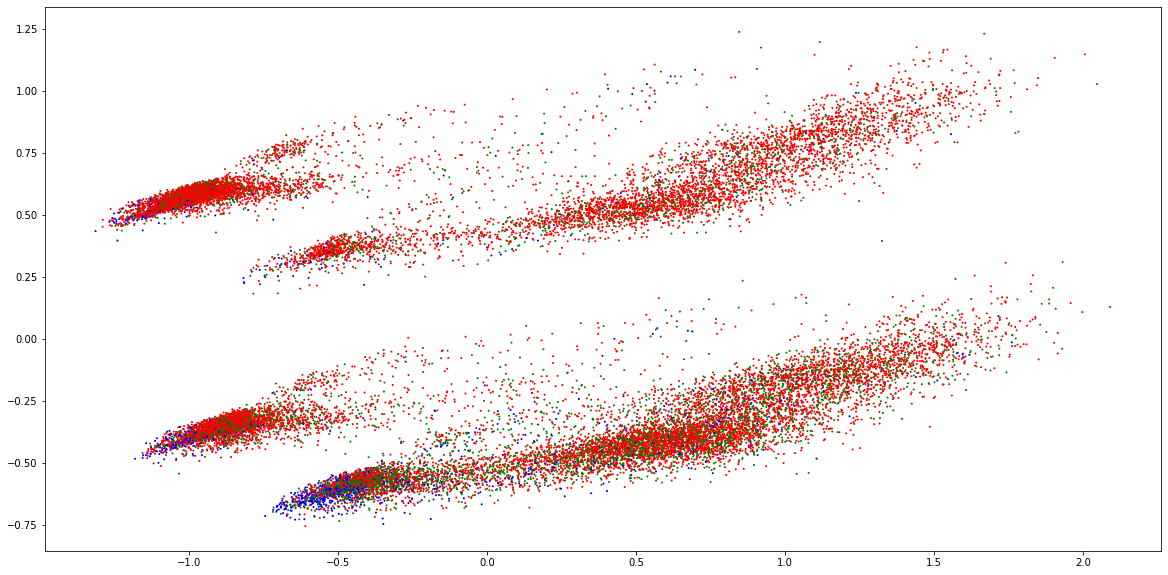

In [22]:
plt.figure(figsize=(20,10))
plt.scatter(transformed_dataset[:, 0], transformed_dataset[:, 1], s=1, color=target_for_color)
    
plt.show()

На глаз данные не очень хорошо разделяются, скорее всего, будут проблемы с классом "2" (он на рисунке изображен зелеными точками)

# Построение модели

Нужно оговориться, что здесь я прикладываю модель, которая выдала лучший результат на валидации. Если вы хотите посмотреть на мои попытки посторить другие классификаторы, то они будут лежать в ноутбуке с названием mediocre_classifiers.ipynb

Будем использовать catboost

Поскольку в датасете дизбаланс по целевой переменной, зададим веса классов

In [23]:
target_df_train = df_train['TARGET'].copy()

In [24]:
class_weight = {
    0: (target_df_train.value_counts()[1] + target_df_train.value_counts()[2]) / len(target_df_train),
    1: (target_df_train.value_counts()[0] + target_df_train.value_counts()[2]) / len(target_df_train),
    2: (target_df_train.value_counts()[0] + target_df_train.value_counts()[1]) / len(target_df_train),
}

Получили следующие веса:

In [25]:
class_weight

{0: 0.29154602177725214, 1: 0.7695852534562212, 2: 0.9388687247665266}

Разделяем данные на обучающую и валидационную выборки

In [26]:
x_train, x_test, y_train, y_test = train_test_split(
    df_train.loc[:, features], target_df_train, test_size=0.2, random_state=49)

Инициализируем классификатор, который будет обучаться на видеокарте

In [27]:
catboost_model = catboost.CatBoostClassifier(
    iterations=100, 
    task_type="GPU",
    devices='0', 
    loss_function='MultiClass', 
    learning_rate=0.1,
    eval_metric='TotalF1', 
    random_seed=49,
    class_weights=class_weight
)

Загрузим предобученную модель

In [28]:
catboost_model.load_model('catboost_model.cbm')

Оценим модель на валидации

In [29]:
predicted_catboost_model = catboost_model.predict(x_test)

Выведем отчет с метриками

In [31]:
print(classification_report(y_test, predicted_catboost_model))

              precision    recall  f1-score   support

           0       0.81      0.74      0.77      3427
           1       0.37      0.46      0.41      1150
           2       0.47      0.47      0.47       328

   micro avg       0.66      0.66      0.66      4905
   macro avg       0.55      0.56      0.55      4905
weighted avg       0.68      0.66      0.67      4905



Выведем confusion-матрицу 

In [33]:
print(confusion_matrix(y_test, predicted_catboost_model))

[[2539  788  100]
 [ 551  527   72]
 [  55  120  153]]


# Проход моделью по тестовым данным, запись в файлы

In [34]:
df_test_features = df_test.loc[:, features]

In [35]:
predicted_catboost_model_prob = catboost_model.predict_proba(df_test_features)

In [36]:
predicted_catboost_model_prob

array([[0.57005182, 0.38549855, 0.04444962],
       [0.49718071, 0.46192631, 0.04089298],
       [0.42959987, 0.15249194, 0.41790819],
       ...,
       [0.63227611, 0.34577886, 0.02194504],
       [0.27771777, 0.59739143, 0.1248908 ],
       [0.38676863, 0.49000022, 0.12323116]])

In [37]:
predicted_classes = np.argmax(predicted_catboost_model_prob, axis=1)

In [38]:
predicted_df = df_test.copy()
all_features = list(predicted_df.keys())
all_features.remove('ID')
predicted_df = predicted_df.drop(all_features, axis=1)

In [39]:
predicted_df['class1'] = predicted_catboost_model_prob[:, 0]
predicted_df['class2'] = predicted_catboost_model_prob[:, 1]
predicted_df['class3'] = predicted_catboost_model_prob[:, 2]
predicted_df['class_name'] = predicted_classes

## Сохраняем данные в файл contest_answer.csv

In [40]:
class_names_df = predicted_df[['ID', 'class_name']]
class_names_df = class_names_df.rename(columns={'class_name': 'TARGET'})

In [41]:
class_names_df.to_csv('contest_answer.csv', index=False)

## Сохраняем данные в файл contest_segments.csv

In [42]:
first_500_of_2_class = predicted_df.sort_values(by=['class2'], ascending=False)[:500]
first_500_of_2_class = first_500_of_2_class[['ID', 'class2']]
first_500_of_2_class = first_500_of_2_class.rename(columns={'class2': 'TARGET'})

In [43]:
first_200_of_3_class = predicted_df.sort_values(by=['class3'], ascending=False)[:200]
first_200_of_3_class = first_200_of_3_class[['ID', 'class3']]
first_200_of_3_class = first_200_of_3_class.rename(columns={'class3': 'TARGET'})

In [44]:
pd.concat([first_500_of_2_class, first_200_of_3_class]).to_csv('contest_segments.csv', index=False)